In [315]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose


In [316]:
data_path = '../data/transformed_output.csv'

In [317]:
df = pd.read_csv(data_path)
df.head(2)

,licencePlate,start_time,end_time,lat,lon,parking_time,vehicleTypeId,zipCode,car_type,area_name,day_of_week_start,hour_of_day_start,day_of_week_end,hour_of_day_end
0,bn32098,2025-07-21 17:37:29,2025-07-22 09:13:29,55.658398,12.514628,936,2,2500,car,Valby,Monday,17,Tuesday,9
1,bn32098,2025-07-22 09:17:29,2025-07-22 09:19:29,55.658348,12.515684,2,2,2500,car,Valby,Tuesday,9,Tuesday,9


#### Create a movement dataframe

In [318]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

df = df.sort_values(by=['licencePlate', 'start_time']).reset_index(drop=True)

# Shift within each licencePlate
df['next_start_time'] = df.groupby('licencePlate')['start_time'].shift(-1)
df['end_lat'] = df.groupby('licencePlate')['lat'].shift(-1)
df['end_lon'] = df.groupby('licencePlate')['lon'].shift(-1)
df['end_zip'] = df.groupby('licencePlate')['zipCode'].shift(-1)

movement_df = df.copy()

movement_df['start_move_time'] = movement_df['end_time']
movement_df['end_move_time'] = movement_df['next_start_time']
movement_df['move_duration'] = movement_df['end_move_time'] - movement_df['start_move_time']

movement_df = movement_df.dropna(subset=['end_move_time']).copy()

movement_df = movement_df.rename(columns={
    'zipCode': 'start_zip'
})

movement_df['start_lat'] = movement_df['lat']
movement_df['start_lon'] = movement_df['lon']

movement_df = movement_df[[
    'licencePlate',
    'car_type',
    'vehicleTypeId',

    'start_move_time',
    'end_move_time',
    'next_start_time',

    'start_lat', 'start_lon',
    'end_lat', 'end_lon',

    'start_zip', 'end_zip',

    'hour_of_day_end',
    'move_duration'
]]

In [319]:
movement_df.head(3)

,licencePlate,car_type,vehicleTypeId,start_move_time,end_move_time,next_start_time,start_lat,start_lon,end_lat,end_lon,start_zip,end_zip,hour_of_day_end,move_duration
0,bn32098,car,2,2025-07-22 09:13:29,2025-07-22 09:17:29,2025-07-22 09:17:29,55.658398,12.514628,55.658348,12.515684,2500,2500.0,9,0 days 00:04:00
1,bn32098,car,2,2025-07-22 09:19:29,2025-07-22 09:23:29,2025-07-22 09:23:29,55.658348,12.515684,55.659286,12.519309,2500,1805.0,9,0 days 00:04:00
2,bn32098,car,2,2025-07-22 12:10:48,2025-07-22 14:24:49,2025-07-22 14:24:49,55.659286,12.519309,55.677685,12.522237,1805,2000.0,12,0 days 02:14:01


In [320]:
n_cars = movement_df['licencePlate'].nunique()
print('Number of cars: ', n_cars
)

Number of cars:  1309


In [321]:
# Daily aggreagates on daily_use dataframe

movement_df['rental_minutes'] = movement_df['move_duration'].dt.total_seconds() / 60
movement_df['date'] = movement_df['start_move_time'].dt.date

daily_use = movement_df.groupby('date')['rental_minutes'].sum().reset_index()
daily_use['total_hours'] = daily_use['rental_minutes'] / 60
daily_use['av_rent_hour_per_car'] = daily_use['total_hours'] / n_cars

In [322]:
daily_use.head(2)

,date,rental_minutes,total_hours,av_rent_hour_per_car
0,2025-07-21,134690.100000,2244.835000,1.714924
1,2025-07-22,368594.666667,6143.244444,4.693082


### 7-day smoothing

In [323]:
# For consistency in plots

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 15
})

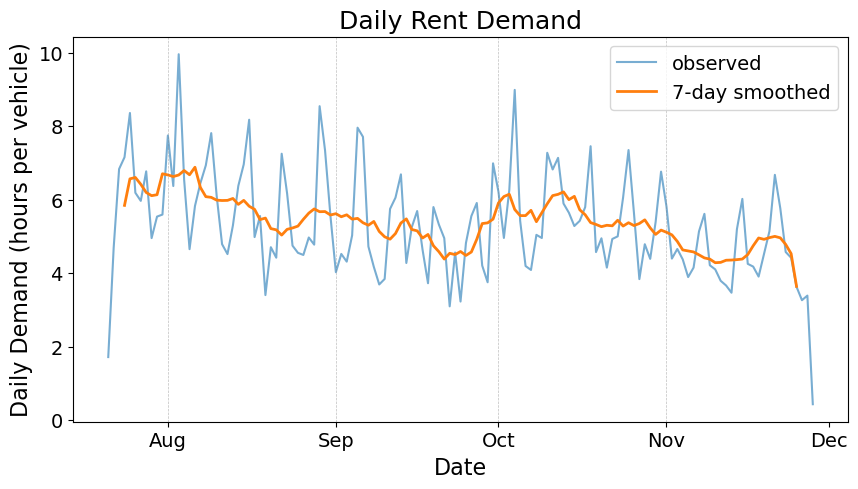

In [324]:
daily_use = daily_use.sort_values('date')
daily_use['rental_smooth'] = daily_use['av_rent_hour_per_car'].rolling(window=7, center=True).mean()

plt.figure(figsize=(10,5))
plt.plot(daily_use['date'], daily_use['av_rent_hour_per_car'], label='observed', alpha=0.6)
plt.plot(daily_use['date'], daily_use['rental_smooth'], label='7-day smoothed', linewidth=2)

# Show months
ax = plt.gca()

for d in pd.date_range(daily_use['date'].min(), daily_use['date'].max(), freq='MS'):
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())      
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  

plt.xlabel('Date')
plt.ylabel('Daily Demand (hours per vehicle)')
plt.title('Daily Rent Demand')
plt.legend()
plt.show()

### Check for outliers

In [325]:
max_individual_trip = movement_df['move_duration'].max()
print('Max individual trip:', max_individual_trip)

Max individual trip: 117 days 13:07:07


In [326]:
max_individual_trip = movement_df['move_duration'].min()
print('Min individual trip:', max_individual_trip)

Min individual trip: 0 days 00:00:12


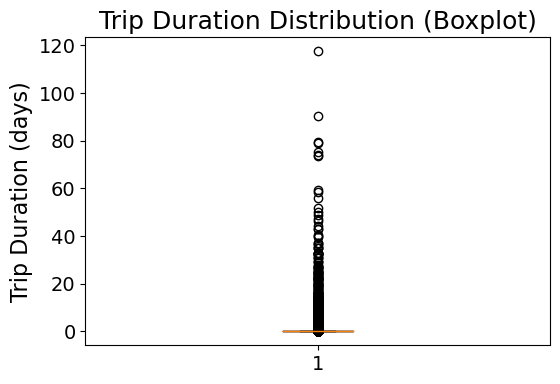

In [327]:
movement_df['move_duration_days'] = movement_df['move_duration'].dt.total_seconds() / 3600 / 24

plt.figure(figsize=(6, 4))
plt.boxplot(movement_df['move_duration_days'], vert=True)
plt.ylabel('Trip Duration (days)')
plt.title('Trip Duration Distribution (Boxplot)')
plt.show()

In [328]:
one_day = pd.Timedelta(days=1)
num_long_trips = (movement_df['move_duration'] > one_day).sum()

print("Number of trips > 1 day:", num_long_trips)
print('Proportion trips >1day: ', num_long_trips/len(movement_df))

unique_plates = movement_df.loc[
    movement_df['move_duration'] > one_day, 'licencePlate'
].nunique()
print("Unique licence plates with rental > 1 day:", unique_plates)

Number of trips > 1 day: 5287
Proportion trips >1day:  0.011253485451565527
Unique licence plates with rental > 1 day: 1271


#### Filter the >1 day trips

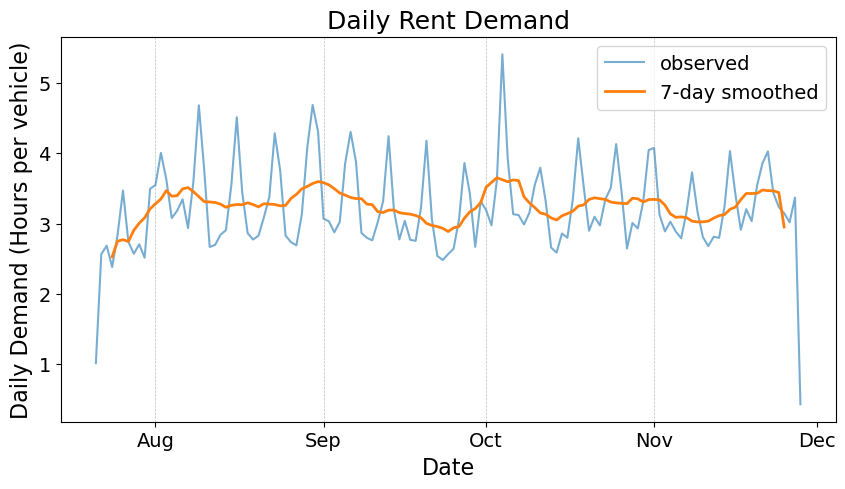

In [329]:
movement_df_filtered = movement_df[movement_df['move_duration'] <= one_day].copy()

daily_use_filtered = movement_df_filtered.groupby('date')['rental_minutes'].sum().reset_index()
daily_use_filtered['total_hours'] = daily_use_filtered['rental_minutes'] / 60
daily_use_filtered['av_rent_hour_per_car'] = daily_use_filtered['total_hours'] / n_cars

daily_use_filtered = daily_use_filtered.sort_values('date')

daily_use_filtered['rental_smooth'] = daily_use_filtered['av_rent_hour_per_car'].rolling(window=7, center=True).mean()

# New plot
plt.figure(figsize=(10,5))
plt.plot(daily_use_filtered['date'], daily_use_filtered['av_rent_hour_per_car'], label='observed', alpha=0.6)
plt.plot(daily_use_filtered['date'], daily_use_filtered['rental_smooth'], label='7-day smoothed', linewidth=2)

ax = plt.gca()
for d in pd.date_range(daily_use_filtered['date'].min(), daily_use_filtered['date'].max(), freq='MS'):
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())       
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  

plt.xlabel('Date')
plt.ylabel('Daily Demand (Hours per vehicle)')
plt.title('Daily Rent Demand')
plt.legend()

plt.savefig('../artifacts/daily_rent_demand.png', dpi=300, bbox_inches='tight')
plt.show()

### Most popular day of the month / day of week

Aggregating by day of the month (only August, September, October) >> full months

In [330]:
full_months = ['2025-08', '2025-09', '2025-10']  

movement_df_filtered['date'] = pd.to_datetime(movement_df_filtered['date'])

movement_df_3m = movement_df_filtered[
    movement_df_filtered['date'].dt.to_period('M').astype(str).isin(full_months)
].copy()


In [340]:
movement_df_3m['day_of_month'] = movement_df_3m['date'].dt.day
movement_df_3m['day_of_week'] = movement_df_3m['date'].dt.day_name()
movement_df_3m['month'] = movement_df_3m['date'].dt.strftime('%Y-%m')

dom_pattern = (
    movement_df_3m.groupby('day_of_month')['rental_minutes'].sum()
    / 60 / n_cars
)
dow_pattern = (
    movement_df_3m.groupby('day_of_week')['rental_minutes'].sum()
    / 60 / n_cars 
)

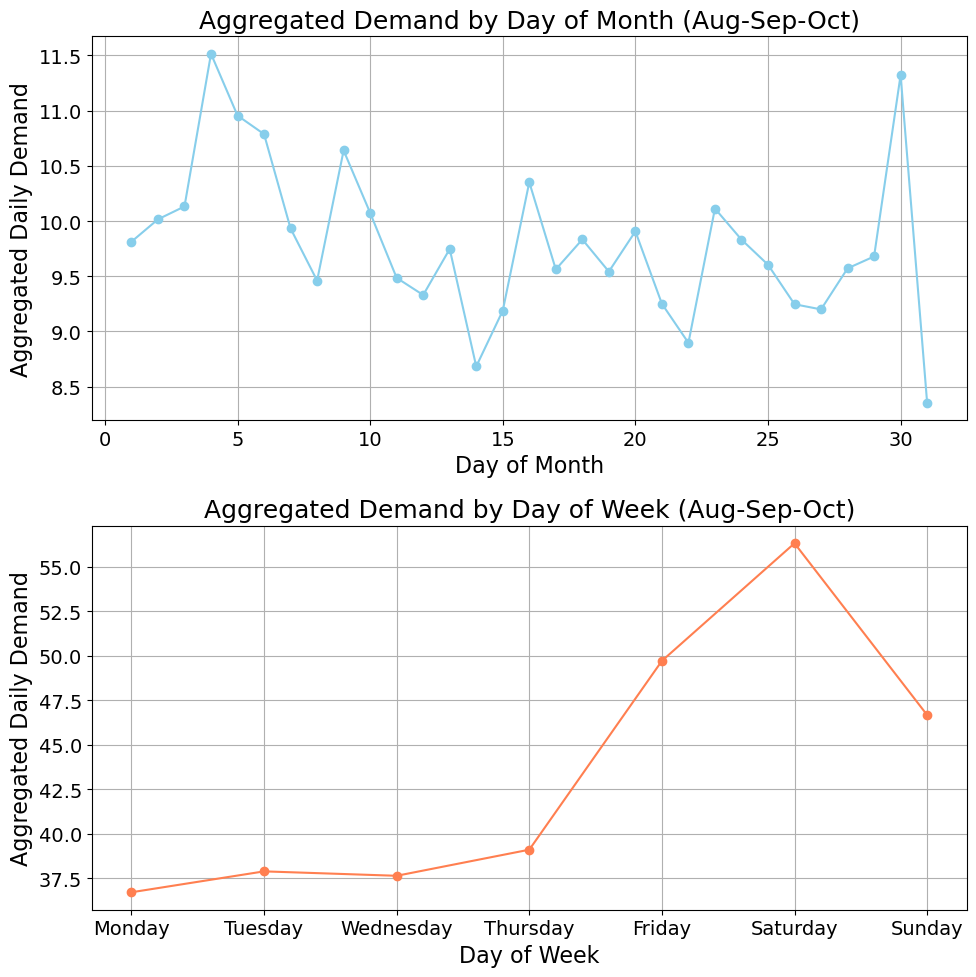

In [341]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_pattern = dow_pattern.reindex(dow_order)

axes[0].plot(dom_pattern.index, dom_pattern.values, marker='o', color='skyblue')
axes[0].set_xlabel("Day of Month")
axes[0].set_ylabel("Aggregated Daily Demand")
axes[0].set_title("Aggregated Demand by Day of Month (Aug-Sep-Oct)")
axes[0].grid(True)

axes[1].plot(dow_pattern.index, dow_pattern.values, marker='o', color='coral')
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Aggregated Daily Demand")
axes[1].set_title("Aggregated Demand by Day of Week (Aug-Sep-Oct)")
axes[1].grid(True)
plt.tight_layout()

plt.savefig('../artifacts/dom-dow.png',dpi=300)
plt.show()

### Comparison between months

### Decomposition

In [342]:
daily_use = daily_use_filtered

In [343]:
daily_use = daily_use.set_index('date')
daily_use.head(1)

,rental_minutes,total_hours,av_rent_hour_per_car,rental_smooth
date,,,,
2025-07-21,79657.966667,1327.632778,1.014234,NaN


In [344]:
result = seasonal_decompose(
    daily_use['av_rent_hour_per_car'],
    model='additive', 
    period=7  # weekly pattern
)

In [345]:
trend = result.trend
seasonal = result.seasonal
resid = result.resid
observed = result.observed

denoised = trend + seasonal
detrended = observed - trend 

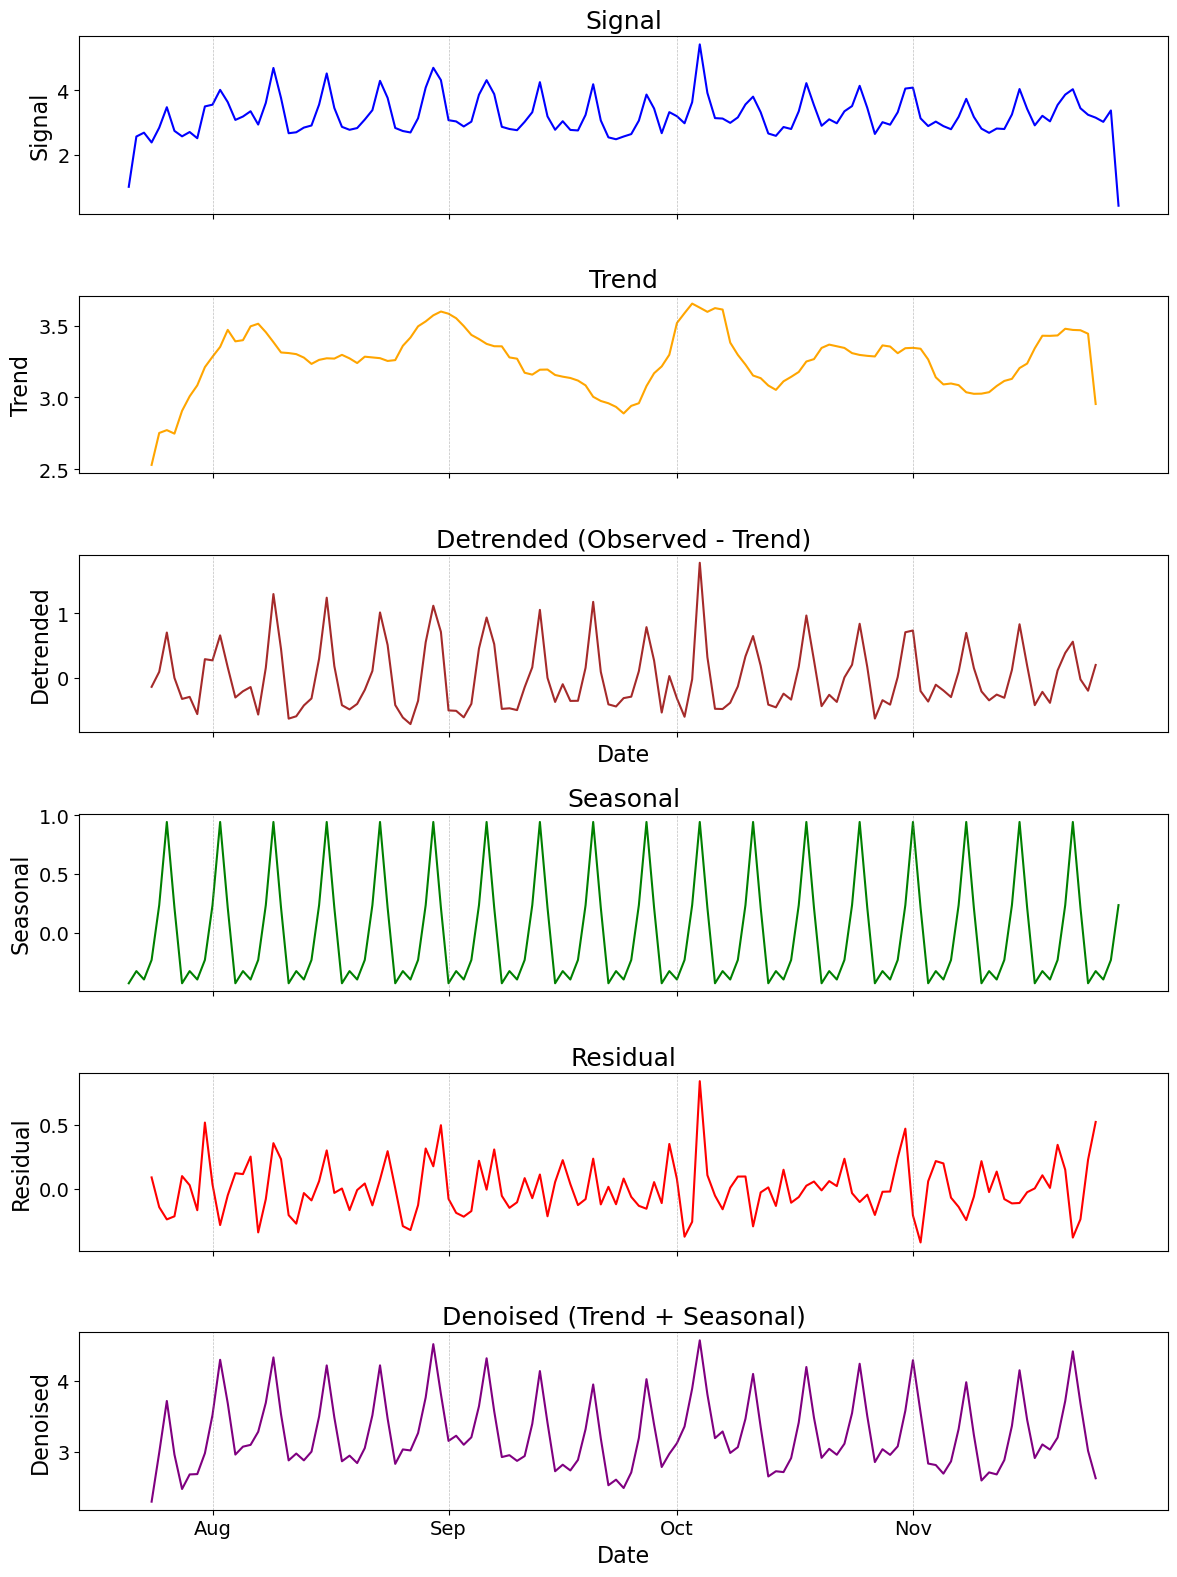

In [347]:
# Plot
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

axes[0].plot(observed.index, observed, color='blue')
axes[0].set_ylabel('Signal')
axes[0].set_title('Signal')

axes[1].plot(trend.index, trend, color='orange')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend')

axes[2].plot(detrended.index, detrended, color='brown')
axes[2].set_ylabel('Detrended')
axes[2].set_title('Detrended (Observed - Trend)')
axes[2].set_xlabel('Date')

axes[3].plot(seasonal.index, seasonal, color='green')
axes[3].set_ylabel('Seasonal')
axes[3].set_title('Seasonal')

axes[4].plot(resid.index, resid, color='red')
axes[4].set_ylabel('Residual')
axes[4].set_title('Residual')

axes[5].plot(denoised.index, denoised, color='purple')
axes[5].set_ylabel('Denoised')
axes[5].set_title('Denoised (Trend + Seasonal)')
axes[5].set_xlabel('Date')

first_days = pd.date_range(start=observed.index.min(), end=observed.index.max(), freq='MS')
for ax in axes:
    for d in first_days:
        ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

axes[-1].set_xticks(first_days)
axes[-1].set_xticklabels(first_days.strftime('%b'))

plt.tight_layout()
plt.savefig('../artifacts/decomposition.png',dpi=300)
plt.show()


## Comparison cars vs vans

In [348]:
vehicle_type_counts = movement_df_filtered.groupby('car_type')['licencePlate'].nunique()
print(vehicle_type_counts)

car_type
car        1286
unknown       6
van          61
Name: licencePlate, dtype: int64


In [349]:
unknown_cars = movement_df_filtered[movement_df_filtered['car_type'].str.lower() == 'unknown']
unknown_vehicle_types = unknown_cars['vehicleTypeId'].unique()
print("Not annotated vehicles:")
print(unknown_vehicle_types)

Not annotated vehicles:
[90 89]


/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_21484/3883263548.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_cars = vehicle_type_counts[0]
/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_21484/3883263548.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n_vans = vehicle_type_counts[2]


Num cars: 1286
Num vans: 61


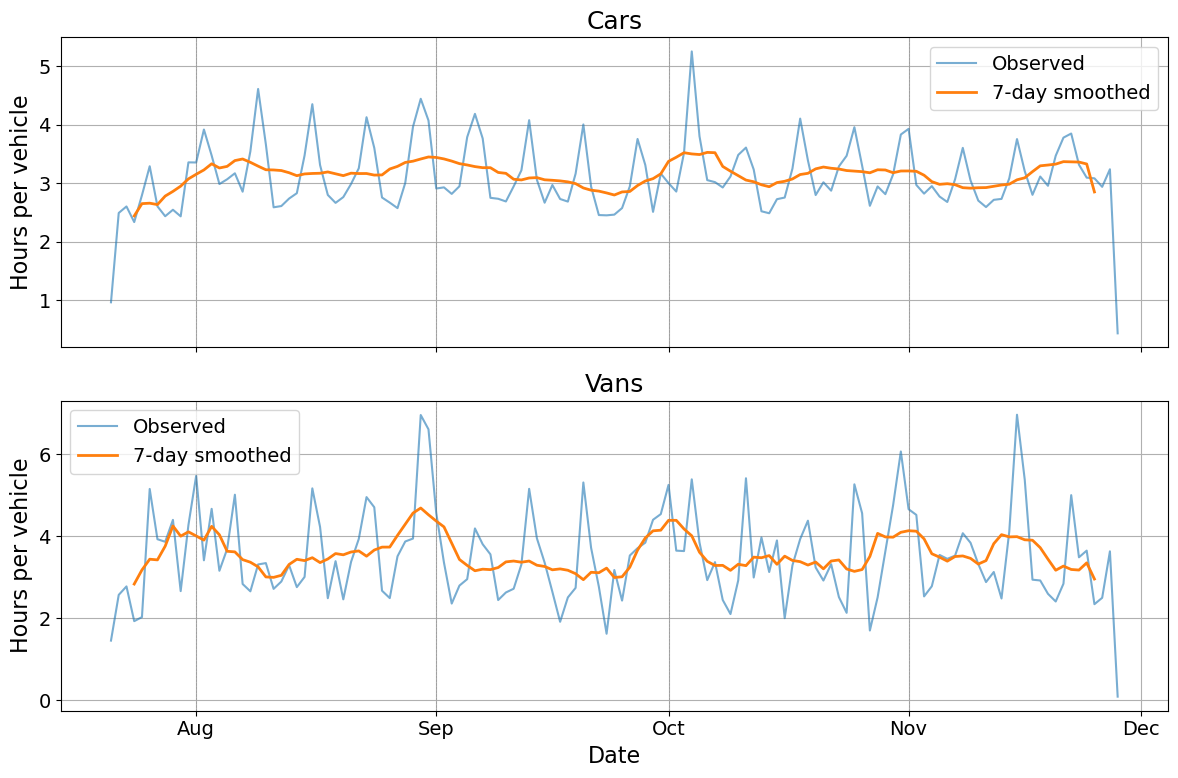

In [ ]:
# n_cars = (movement_df_filtered['vehicle_type'] == 'car').sum()
# n_vans = (movement_df_filtered['vehicle_type'] == 'van').sum()

n_cars = vehicle_type_counts[0]
n_vans = vehicle_type_counts[2]
print('Num cars:', n_cars)
print('Num vans:', n_vans)

known_df = movement_df_filtered[
    movement_df_filtered['car_type'].str.lower() != 'unknown'
]

daily_use_type = (
    known_df.groupby(['date','car_type'])['rental_minutes']
    .sum()
    .reset_index()
)

daily_use_type['total_hours'] = daily_use_type['rental_minutes'] / 60
daily_use_type['av_rent_hour_per_vehicle'] = daily_use_type.apply(
    lambda row: row['total_hours'] / (n_cars if row['car_type']=='car' else n_vans), axis=1
)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i, vtype in enumerate(['car','van']):
    df_plot = daily_use_type[daily_use_type['car_type']==vtype].sort_values('date')
    df_plot['rental_smooth'] = df_plot['av_rent_hour_per_vehicle'].rolling(window=7, center=True).mean()
    
    axes[i].plot(df_plot['date'], df_plot['av_rent_hour_per_vehicle'], label=f'Observed', alpha=0.6)
    axes[i].plot(df_plot['date'], df_plot['rental_smooth'], label='7-day smoothed', linewidth=2)
    
    for d in pd.date_range(df_plot['date'].min(), df_plot['date'].max(), freq='MS'):
        axes[i].axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    axes[i].set_ylabel('Hours per vehicle')
    axes[i].set_title(f'{vtype.capitalize()}s')
    axes[i].legend()
    axes[i].grid(True)

axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel('Date')

plt.tight_layout()
plt.show()

### Decomposition - Car vs Vans

#### Trend comparison

In [351]:
results = {}  

for vtype in ['car', 'van']:

    s = (
        daily_use_type[daily_use_type['car_type'] == vtype]
        .sort_values('date')
        .set_index('date')['av_rent_hour_per_vehicle']
        .asfreq('D')                  
        .interpolate('time')             
    )
    result = seasonal_decompose(
    s,
    model='additive',
    period=7,   
    extrapolate_trend='freq' 
    )

    results[vtype] = result

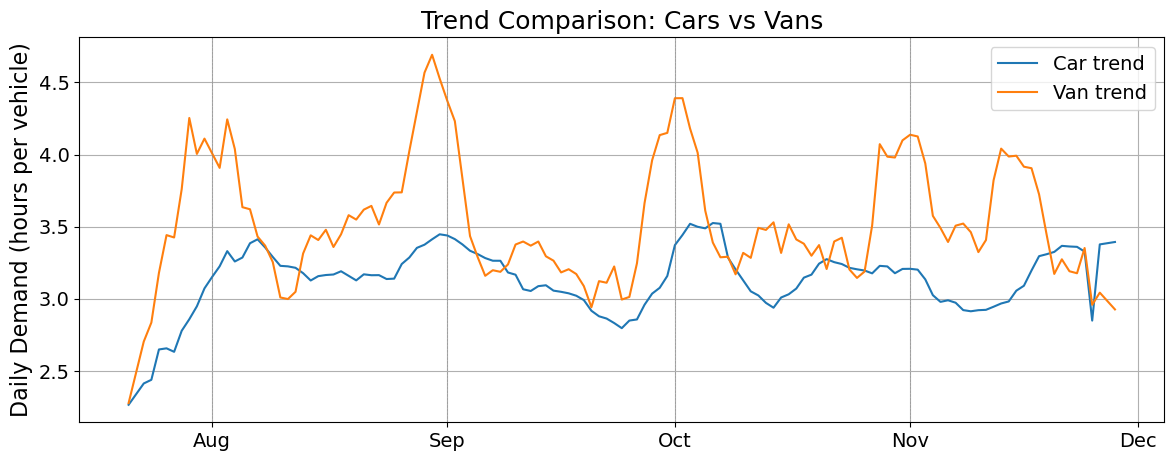

In [366]:
car_trend = results['car'].trend.rename("car_trend")
van_trend = results['van'].trend.rename("van_trend")

trend_df = pd.concat([car_trend, van_trend], axis=1)

plt.figure(figsize=(14,5))
plt.plot(trend_df.index, trend_df['car_trend'], label="Car trend")
plt.plot(trend_df.index, trend_df['van_trend'], label="Van trend")

ax = plt.gca()
first_days = pd.date_range(
    start=trend_df.index.min(),
    end=trend_df.index.max(),
    freq='MS'        
)

for d in first_days:
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator())   
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


plt.title("Trend Comparison: Cars vs Vans")
plt.ylabel("Daily Demand (hours per vehicle)")
plt.legend()
plt.grid(True)
plt.savefig('../artifacts/car-vans-trends', dpi=300)
plt.show()

### Seasonal comparison

In [354]:
car_resid = results['car'].resid.dropna()
van_resid = results['van'].resid.dropna()

car_seasonal = results['car'].seasonal
van_seasonal = results['van'].seasonal


In [355]:
car_seasonal_strength = 1 - (car_resid.var() / (car_resid + car_seasonal).var())
van_seasonal_strength = 1 - (van_resid.var() / (van_resid + van_seasonal).var())

print("\n=== Seasonal Strength (0 = weak, 1 = strong) ===")
print(f"Car seasonal strength: {car_seasonal_strength:.3f}")
print(f"Van seasonal strength: {van_seasonal_strength:.3f}")

if car_seasonal_strength > van_seasonal_strength:
    print("→ Cars have stronger weekly seasonality relative to noise.")
else:
    print("→ Vans have stronger weekly seasonality relative to noise.")



=== Seasonal Strength (0 = weak, 1 = strong) ===
Car seasonal strength: 0.598
Van seasonal strength: 0.446
→ Cars have stronger weekly seasonality relative to noise.


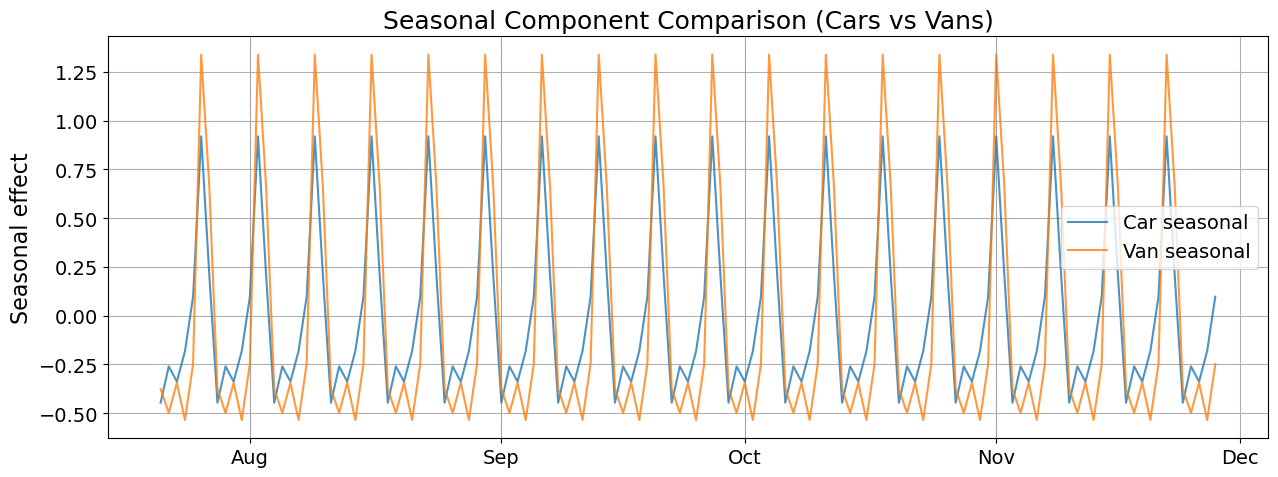

In [356]:
plt.figure(figsize=(13,5))
plt.plot(car_seasonal.index, car_seasonal, label="Car seasonal", alpha=0.8)
plt.plot(van_seasonal.index, van_seasonal, label="Van seasonal", alpha=0.8)
plt.title("Seasonal Component Comparison (Cars vs Vans)")
plt.ylabel("Seasonal effect")
plt.legend()
plt.grid(True)

ax = plt.gca()
first_days = pd.date_range(
    start=car_seasonal.index.min(),
    end=car_seasonal.index.max(),
    freq='MS'
)
for d in first_days:
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

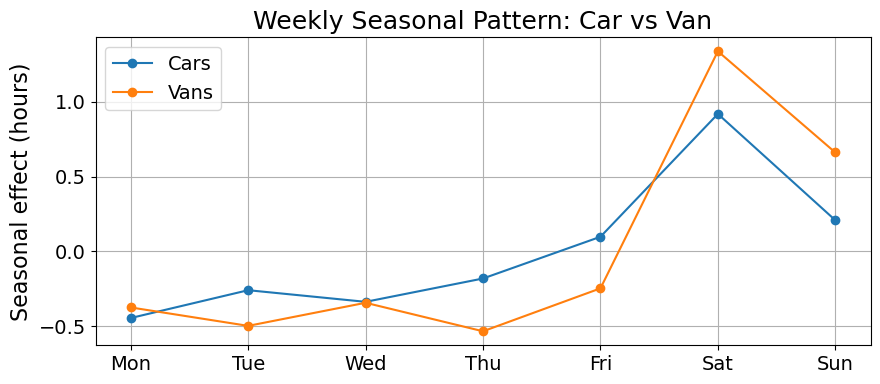

In [358]:
car_season = results['car'].seasonal.groupby(results['car'].seasonal.index.dayofweek).mean()
van_season = results['van'].seasonal.groupby(results['van'].seasonal.index.dayofweek).mean()

plt.figure(figsize=(10,4))
plt.plot(car_season.index, car_season.values, marker='o', label='Cars')
plt.plot(van_season.index, van_season.values, marker='o', label='Vans')
plt.xticks(range(7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title("Weekly Seasonal Pattern: Car vs Van")
plt.ylabel("Seasonal effect (hours)")
plt.legend()
plt.grid(True)
plt.savefig('../artifacts/car-vans-weeklyseasonal', dpi=300)
plt.show()

The graph shows the seasonal component, which is the part of the signal that repeats every week (removed the trend, noise and irregular fluctuations.)

Underlying weekly repeating pattern.

### Residuals comparison

In [359]:
car_resid_var = car_resid.var()
van_resid_var = van_resid.var()

print("=== Residual Variance ===")
print(f"Cars residual variance: {car_resid_var:.4f}")
print(f"Vans residual variance: {van_resid_var:.4f}")

if car_resid_var < van_resid_var:
    print("→ Cars have more predictable demand (lower noise).")
else:
    print("→ Vans have more predictable demand (lower noise).")

=== Residual Variance ===
Cars residual variance: 0.1243
Vans residual variance: 0.5384
→ Cars have more predictable demand (lower noise).


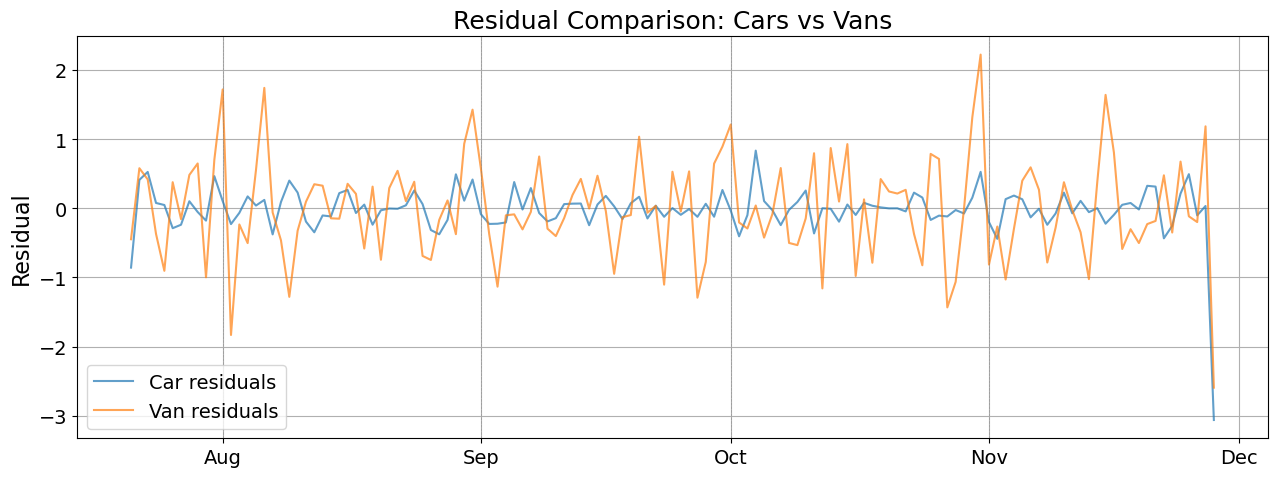

In [361]:
# Plot residuals

plt.figure(figsize=(13,5))
plt.plot(car_resid.index, car_resid, label="Car residuals", alpha=0.7)
plt.plot(van_resid.index, van_resid, label="Van residuals", alpha=0.7)
plt.title("Residual Comparison: Cars vs Vans")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)

ax = plt.gca()
first_days = pd.date_range(
    start=car_resid.index.min(),
    end=car_resid.index.max(),
    freq='MS'
)
for d in first_days:
    ax.axvline(d, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.savefig('../artifacts/car-vans-residual', dpi=300)
plt.show()

____________
## Is data stationary?

In [362]:
from statsmodels.tsa.stattools import adfuller, kpss

In [363]:
df = daily_use.copy()
df['av_hours_log'] = np.log(df['av_rent_hour_per_car'])
df['av_hours_diff'] = df['av_rent_hour_per_car'] - df['av_rent_hour_per_car'].shift(1)
df['av_hours_return'] = df['av_rent_hour_per_car'] / df['av_rent_hour_per_car'].shift(1)
df['av_hours_return_log'] = np.log(df['av_hours_return'])
df['av_hours_log_diff'] = df['av_hours_log'] - df['av_hours_log'].shift(1)


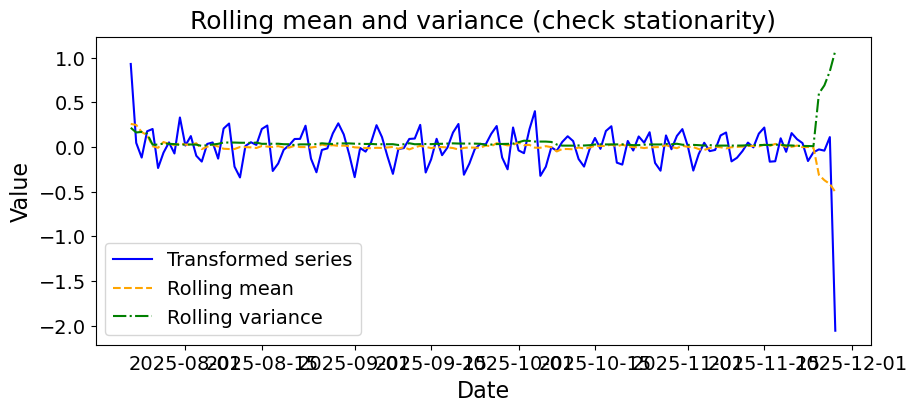

In [364]:
var = 'av_hours_log_diff'

df_plot = df[[var]].dropna()
rolling_mean = df_plot[var].rolling(window=7, min_periods=1, center=True).mean()
rolling_var = df_plot[var].rolling(window=7, min_periods=1, center=True).var()

plt.figure(figsize=(10,4))
plt.plot(df_plot.index, df_plot[var], color='blue', label='Transformed series')
plt.plot(df_plot.index, rolling_mean, '--', color='orange', label='Rolling mean')
plt.plot(df_plot.index, rolling_var, '-.', color='green', label='Rolling variance')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling mean and variance (check stationarity)')
plt.legend()
plt.show()


In [365]:
adf_result = adfuller(df_plot[var])
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical values:", adf_result[4])

kpss_result = kpss(df_plot[var], regression='c', nlags='auto')
print("KPSS Test Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
print("Critical values:", kpss_result[3])


ADF Test Statistic: -2.1141165783104685
p-value: 0.23887627154216162
Critical values: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}
KPSS Test Statistic: 0.39077273919155153
p-value: 0.08113244000364159
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


#### Result: Series is stationary